# Bayes 分类器设计

## 1. 应用单个特征进行实验
应用单个特征进行实验:以(a)身高、(b)体重或(c)鞋码尺寸数据作为特征，在正态分布假设下利用最大似然法或者贝叶斯估计法估计分布密度参数(只利用训练数据估计密度)，建立最小错误率Bayes 分类器，写出得到的决策规则，将该分类器应用到测试样本，考察测试错误情况。在分类器设计时可以考察采用不同先验概率(如0.5对0.5, 0.75对0.25, 0.9对0.1等)进行实验，考察对决策规则和错误率的影响。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['font.sans-serif'] = ['Songti SC']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def loadDataSet():
    pathfile = '..\data.csv'
    dataset = pd.read_csv(pathfile,encoding="utf-8-sig")
    data=pd.DataFrame(dataset)
    data.replace('男\ufeff','男',inplace=True)    
    data.replace('女\ufeff','女',inplace=True)
    data.replace('\ufeff女','女',inplace=True)
    label = dataset.iloc[:, 3].values
    data = dataset.iloc[:, 0:3].values
    return np.array(data), np.array(label)

In [3]:
def plot(data, label, feature1, feature2):
    male_fea1 = data[label == '男'][:, feature1]
    female_fea1 = data[label == '女'][:, feature1]
    male_fea2 = data[label == '男'][:, feature2]
    female_fea2 = data[label == '女'][:, feature2]
    f = {1: '身高', 2: '体重', 3: '鞋码'}
    plt.figure()
    s1 = plt.scatter(male_fea1, male_fea2, c='r', marker='o', label='男')
    s2 = plt.scatter(female_fea1, female_fea2, c='b', marker='x', label='女')
    plt.xlabel(f[feature1+1])
    plt.ylabel(f[feature2+1])
    plt.legend(loc='best')
    plt.show()

def plot3D(data, label):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    for i in range(len(label)):
        if label[i] == '男':
            s1 = ax.scatter(data[i, 0], data[i, 1], data[i, 2], c='r')
        else:
            s2 = ax.scatter(data[i, 0], data[i, 1], data[i, 2], c='b')
    ax.set_xlabel('身高')
    ax.set_ylabel('体重')
    ax.set_zlabel('鞋码')
    ax.legend((s1, s2), ('boys', 'girls'), loc='best')
    plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Songti SC
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 36523 (\N{CJK UNIFIED IDEOGRAPH-8EAB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\I

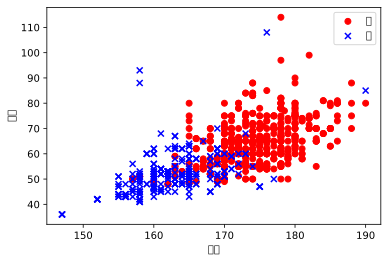

c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 38795 (\N{CJK UNIFIED IDEOGRAPH-978B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 30721 (\N{CJK UNIFIED IDEOGRAPH-7801}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


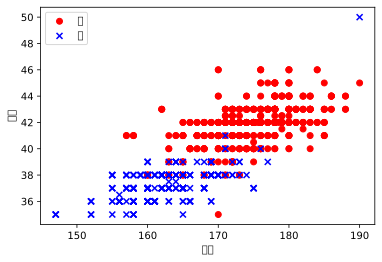

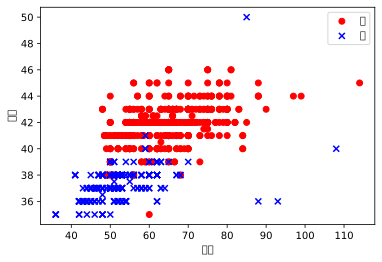

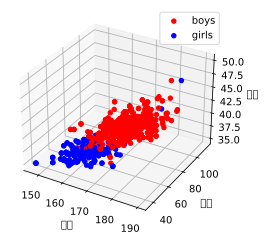

In [4]:
data, label = loadDataSet()
plot(data, label, 0, 1)
plot(data, label, 0, 2)
plot(data, label, 1, 2)
plot3D(data, label)

In [5]:
def split_dataset(data, label, ratio=0.8):
    # 划分训练集和测试集
    index = np.arange(len(label))
    np.random.shuffle(index)
    train_index = index[:int(len(index)*ratio)]
    test_index = index[int(len(index)*ratio):]
    train_data = data[train_index]
    train_label = label[train_index]
    test_data = data[test_index]
    test_label = label[test_index]
    return train_data, train_label, test_data, test_label

In [6]:
train_data, train_label, test_data, test_label = split_dataset(data, label, ratio=0.8)

## 一元正态分布下的最大似然估计
假设样本 $X_{m\times n}$ 服从正态分布, 用最大似然估计估计正态分布概率密度函数中的均值 $\mu$ 和方差 $\sigma^2$。

正态分布的概率密度函数为:
$$
f(x)=\frac{1}{\sqrt{2 \pi} \sigma} e^{-\frac{(x-\mu)^2}{2 \sigma^2}}
$$
联合概率为：
$$
l(\theta)=p(x_1, x_2, \cdots, x_n | \theta)=\prod_{i=1}^n p(x_i | \theta)=(\frac{1}{\sqrt{2 \pi} \sigma})^n e^{-\sum\limits_{i=1}^n\frac{(x_i-\mu)^2}{2 \sigma^2}}
$$


对似然函数求对数：
$$
\begin{aligned}
\ln l(\theta)=\ln((\frac{1}{\sqrt{2 \pi} \sigma})^n e^{-\sum\limits_{i=1}^n\frac{(x_i-\mu)^2}{2 \sigma^2}})


& =n \ln(\frac{1}{\sqrt{2 \pi} \sigma})-\sum\limits_{i=1}^{n}{\frac{(x_i-\mu)^2}{2 \sigma^2}}\\
& = -n\ln (\sqrt{2 \pi} \sigma)-\frac{1}{2\sigma^2}\sum\limits_{i=1}^{n}(x_i-\mu)^2\\
\end{aligned}
$$
对 $\mu$ 求导:
$$
\begin{aligned}
\frac{\partial \ln l(\theta)}{\partial \mu} &=\frac{\partial\left(-\frac{1}{2 \sigma^2} \sum\limits_{i=1}^n\left(x_i-\mu\right)^2\right)}{\partial \mu} \\
& =-\frac{1}{2 \sigma^2}(-2 \sum_{i=1}^n x_i+2 n \mu)
\end{aligned}
$$
令 $\frac{\partial \ln L}{\partial \mu}=0$ :
$$
\hat\mu=\frac{1}{n} \sum\limits_{i=1}^{n}x_i
$$
对$\sigma^2$求导：
$$
\begin{aligned}
\frac{\partial \ln l(\theta)}{\partial \sigma^2} &=\frac{\partial(-n\ln (\sqrt{2 \pi} \sigma)-\frac{1}{2\sigma^2}\sum\limits_{i=1}^{n}(x_i-\mu)^2)}{\partial \sigma^2} \\
&=\frac{\partial(-\frac{n}{2}\ln \sigma^2-\frac{1}{2\sigma^2}\sum\limits_{i=1}^{n}(x_i-\mu)^2)}{\partial \sigma^2} \\
&=-\frac{n}{2}\frac{1}{\sigma^2}+\frac{1}{2\sigma^4}\sum\limits_{i=1}^{n}(x_i-\mu)^2
\end{aligned}
$$
令 $\frac{\partial \ln L}{\partial \sigma^2}=0$ :
$$
\hat{\sigma^2}=\frac{1}{n}\sum\limits_{i=1}^n(x_i-\mu)^2
$$
## 最小错误率Bayes分类器
设样本$\boldsymbol{x}=\left[x_1, x_2, \ldots, x_n\right]$，分成$k$类$c_1,\dots,c_k$，$P\left(c_i\right)$ 为先验概率, $p\left(\boldsymbol{x} \mid c_i\right)$ 为样本 $\boldsymbol{x}$ 的类条件概率密度。
$$
P\left(c_i \mid \boldsymbol{x}\right)=\frac{p\left(\boldsymbol{x} \mid c_i\right) P\left(c_i\right)}{p(\boldsymbol{x})}=\frac{p\left(\boldsymbol{x} \mid c_i\right) P\left(c_i\right)}{\sum\limits_{j=1}^n p\left(\boldsymbol{x} \mid c_i\right) P\left(c_i\right)}, i=1,2, \ldots, k
$$
最小错误率贝叶斯决策规则$\boldsymbol{y}=\arg \max P\left(c_i \mid \boldsymbol{x}\right)$。

首先根据假设得到先验概率$P(c_i)$，由最大似然估计可得到类条件概率密度函数 $p\left(\boldsymbol{x} \mid c_i\right)$ ，求得后验概率$P\left(c_i \mid x\right)$，并选择后验概率大的那个作为分类结果。

In [8]:
def mean(x):
    '''
    计算均值
    '''
    mu = 0
    for i in range(len(x)):
        mu += x[i]
    return mu/len(x)

def std(x):
    '''
    计算标准差
    '''
    sigma = 0
    for i in range(len(x)):
        sigma += (x[i] - mean(x))**2
    return np.sqrt(sigma/len(x))

def gaussian(x, mu, sigma):
    '''
    计算高斯分布
    '''
    return np.exp(-((x-mu)**2)/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

def feature_extract(data, label, feature):
    male_data = data[label == '男'][:, feature]
    female_data = data[label == '女'][:, feature]
    return mean(male_data), mean(female_data), std(male_data), std(female_data)

def posterior(x, mu1, mu2, sigma1, sigma2):
    '''
    计算后验概率
    '''
    pre = [0.5, 0.75, 0.9] # 先验概率
    pre_male = pre[2]
    pre_female = 1 - pre_male
    p1 = gaussian(x, mu1, sigma1)
    p2 = gaussian(x, mu2, sigma2)
    return pre_male*p1/(pre_male*p1 + pre_female*p2), pre_female*p2/(pre_male*p1 + pre_female*p2)

def bayes(data, label, feature):
    '''
    return:bayes决策标签结果，相应正样本后验概率
    '''
    mu1, mu2, sigma1, sigma2 = feature_extract(data, label, feature)
    label_pred = []
    pos_posterior = []  #positive
    for i in range(len(data)):
        p1, p2 = posterior(data[i, feature], mu1, mu2, sigma1, sigma2)
        pos_posterior.append(p1)  #正样本概率
        if p1 > p2:
            label_pred.append('男')
        else:
            label_pred.append('女')
    return label_pred, pos_posterior

def accuracy(label_pred, label):
    acc = 0
    for i in range(len(label)):
        if label_pred[i] == label[i]:
            acc += 1
    return acc/len(label)

In [9]:
accuracy(bayes(test_data, test_label, 0)[0], test_label)

0.8125

### 若两个特征不相关

In [10]:
def posterior2(x, y, mu1_f1, mu2_f1, sigma1_f1, sigma2_f1, mu1_f2, mu2_f2, sigma1_f2, sigma2_f2):
    '''
    计算（两个不相关特征的）后验概率
    '''
    pre = [0.5, 0.75, 0.9] # 先验概率
    pre_male = pre[0]
    pre_female = 1 - pre_male
    p1_f1 = gaussian(x, mu1_f1, sigma1_f1)
    p2_f1 = gaussian(x, mu2_f1, sigma2_f1)

    p1_f2 = gaussian(y, mu1_f2, sigma1_f2)
    p2_f2 = gaussian(y, mu2_f2, sigma2_f2)

    ln_p1 = np.log(p1_f1) + np.log(p1_f2) + np.log(pre_male)
    ln_p2 = np.log(p2_f1) + np.log(p2_f2) + np.log(pre_female)
    return ln_p1, ln_p2


def bayes2(data, label, feature1, feature2):
    # 男女生特征1、2的均值与标准差
    mu1_f1, mu2_f1, sigma1_f1, sigma2_f1 = feature_extract(data, label, feature1)
    mu1_f2, mu2_f2, sigma1_f2, sigma2_f2 = feature_extract(data, label, feature2)
    label_pred = []
    pos_posterior = []  #positive
    for i in range(len(data)):
        p1, p2 = posterior2(data[i, feature1], data[i, feature2], mu1_f1, mu2_f1, sigma1_f1, sigma2_f1, mu1_f2, mu2_f2, sigma1_f2, sigma2_f2)
        pos_posterior.append(p1)
        if p1 > p2:
            label_pred.append('男')
        else:
            label_pred.append('女')
    return label_pred, pos_posterior


In [23]:
accuracy(bayes2(train_data, train_label, 0, 1)[0], train_label)

0.8721590909090909

### 若两个特征相关
多元正态分布的概率密度函数：
$$
p(x) = \frac{1}{{(2\pi)^{\frac{d}{2}} \lvert \Sigma \rvert ^{\frac{1}{2}}}}e^{-\frac{1}{2}(x- \mu)^ T \Sigma ^{-1} (x-\mu)} \tag{1}
$$
其中：
$$
x = [x_1, x_2, ... , x_d]^T 是d维列向量； \\
\mu = [\mu_1, \mu_2, ... , \mu_d]^T 是d维列向量；\\
\Sigma 是d×d维协方差矩阵， \Sigma^{-1}是\Sigma的逆矩阵， \lvert \Sigma \rvert 是\Sigma的行列式.
$$
联合概率为：
$$
l(\theta)=p(x_1, x_2, \cdots, x_n | \theta)=\prod_{i=1}^n p(x_i | \theta)=p(x) =(\frac{1}{{(2\pi)^{\frac{d}{2}} \lvert \Sigma \rvert ^{\frac{1}{2}}}})^ne^{-\frac{1}{2}\sum\limits_{i=1}^n(x_i- \mu)^ T \Sigma ^{-1} (x_i-\mu)}
$$


对似然函数求对数：
$$
\begin{aligned}
\ln l(\theta)=\ln((\frac{1}{{(2\pi)^{\frac{d}{2}} \lvert \Sigma \rvert ^{\frac{1}{2}}}})^ne^{-\frac{1}{2}\sum\limits_{i=1}^n(x- \mu)^ T \Sigma ^{-1} (x-\mu)})


& =-\frac{n d}{2} \ln (2 \pi)-\frac{n}{2} \ln |\Sigma|-\frac{1}{2} \sum_{i=1}^n\left[\left(x_i-\boldsymbol{\mu}\right)^T \Sigma^{-1}\left(x_i-\boldsymbol{\mu}\right)\right]
\end{aligned}
$$
对 $\mu$ 求导:
$$
\begin{aligned}
\frac{\partial \ln l(\theta)}{\partial \mu} &=\frac{\partial(-\frac{1}{2} \sum_{i=1}^n\left[\left(x_i-\boldsymbol{\mu}\right)^T \Sigma^{-1}\left(x_i-\boldsymbol{\mu}\right)\right])}{\partial \mu} \\& =-\Sigma^{-1} \cdot \sum_{i=1}^n\left(x_i-\boldsymbol{\mu}\right)
\end{aligned}
$$
令 $\frac{\partial \ln L}{\partial \mu}=0$ :
$$
\hat{\mu}=\frac{1}{n} \sum_i^n x_i
$$
对$\Sigma$求导：
$$
\frac{\partial \ln l(\theta)}{\partial \Sigma}=-\frac{n}{2} \Sigma^{-1}+\frac{1}{2} \Sigma^{-1} \sum_{i=1}^n\left[\left(x_i-\boldsymbol{\mu}\right)\left(x_i-\boldsymbol{\mu}\right)^T\right] \Sigma^{-1}
$$
令 $\frac{\partial \ln L}{\partial \Sigma}=0$ :
$$
\hat{\Sigma} = \frac{1}{n} \sum ^n_i [(x_i-\mu)(x_i-\mu)^T]
$$

判别函数：
$$
g_i(x) = ln(p(x|\omega_i)P(\omega_i)) \tag{2}
$$
将（1）式带入（2）式得：
$$
g_i(x) = -\frac{1}{2}(x- \mu)^ T \Sigma_i ^{-1} (x-\mu) - \frac{d}{2} ln(2\pi)
-\frac{1}{2}ln(\lvert \Sigma_i \rvert) + lnP(\omega_i) \tag{3}
$$
其中$\mu$与$\Sigma$的最大似然估计值分别为：

$$
\hat{\mu} = \frac{1}{n} \sum ^n_i x_i  \\
\hat{\Sigma} = \frac{1}{n} \sum ^n_i [(x_i-\mu)(x_i-\mu)^T]
$$

In [30]:
def Sigma(data, mu):
    '''
    计算协方差矩阵
    '''
    sigma = np.array([[0.0,0.0],[0.0,0.0]])
    for i in range(len(data)):
        sigma += (data[i] - mu) @ (data[i] - mu).T
        
    return sigma / len(data)


def feature_extract_n(data, label, feature1, feature2):
    male_data1 = data[label == '男'][:, feature1]
    male_data2 = data[label == '男'][:, feature2]
    male_data = []
    for i in range(len(male_data1)):
        male_data.append(np.array([male_data1[i], male_data2[i]]).reshape(1,-1).T)

    female_data1 = data[label == '女'][:, feature1]
    female_data2 = data[label == '女'][:, feature2]
    female_data = []
    for i in range(len(female_data1)):
        female_data.append(np.array([female_data1[i], female_data2[i]]).reshape(1,-1).T)
    
    mu1_f1 = mean(male_data1)
    mu1_f2 = mean(male_data2)
    mu2_f1 = mean(female_data1)
    mu2_f2 = mean(female_data2)
    mu = [np.array([mu1_f1, mu1_f2]).reshape(1,-1).T, np.array([mu2_f1, mu2_f2]).reshape(1,-1).T]
    sigma = [Sigma(male_data, mu[0]), Sigma(female_data, mu[1])]
    
    return mu, sigma


def posterior_n(x, mu, sigma):
    '''
    计算高维正态分布的后验概率
    
    x为特征向量
    
    mu为均值向量列表
    mu[0]表示男生的特征向量
    mu[1]表示女生的特征向量
    
    Sigma为d维协方差矩阵列表
    Sigma[0]表示男生的协方差矩阵
    Sigma[1]表示女生的协方差矩阵
    
    '''
    
    pre = [0.5, 0.75, 0.9] # 先验概率
    pre_male = pre[0]
    pre_female = 1 - pre_male
    
    d = len(x)
    g1 = - 0.5 * (x - mu[0]).reshape(-1).T @ np.linalg.inv(sigma[0]) @ (x - mu[0]) - 0.5 * d * np.log(2 * np.pi) - 0.5 * np.log(np.linalg.det(sigma[0])) + np.log(pre_male)
    g2 = - 0.5 * (x - mu[1]).reshape(-1).T @ np.linalg.inv(sigma[1]) @ (x - mu[1]) - 0.5 * d * np.log(2 * np.pi) - 0.5 * np.log(np.linalg.det(sigma[1])) + np.log(pre_female)
    
    return g1, g2


def Draw2DDSurface(mu, sigma, data1, data2):
    '''
    绘制概率密度曲线
    
    '''
    x = data1
    y = data2
    M= 1000
    xx, yy = np.meshgrid(np.linspace(160,190,M), np.linspace(40, 90, M))
    d = np.dstack([xx, yy])
    i = [t for t in range(M)]
    j = [t for t in range(M)]
    p1 = np.zeros((M,M))
    for m in i:
        for n in j:
             p1[m][n] = 1/(pow(2 * np.pi, (len(data1)/2)) * np.linalg.det(sigma[0]) ** 0.5) *  np.exp(-0.5 * (d[m][n].reshape(2,1) - mu[0]).T @ np.linalg.inv(sigma[0]) @ (d[m][n].reshape(2,1) - mu[0]))
    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(dpi = 100)
    ax = plt.subplot(111, projection='3d')
    ax.plot_surface(xx, yy, p1, cmap='gnuplot', alpha=0.9)
    ax.set_xlabel('height')
    ax.set_ylabel('weight')
    ax.set_zlabel('probLine')
    plt.title("Boy's Density Function",loc="center")
    plt.show()
    
    plt.figure()
    plt.xlabel("height")
    plt.xlabel("weight")
    plt.plot(x, y, 'ko', alpha=0.3)
    plt.contour(xx, yy, p1, alpha=1.0, zorder=10)
    plt.xlim(160, 190)
    plt.ylim(40, 90)
    plt.title("Projection of Boy's Density Function",loc="center")
    plt.show()
    
    x = data1
    y = data2
    M= 1000
    xx, yy = np.meshgrid(np.linspace(145,180,M), np.linspace(30, 70, M))
    d = np.dstack([xx, yy])
    i = [t for t in range(M)]
    j = [t for t in range(M)]
    p2 = np.zeros((M,M))
    for m in i:
        for n in j:
             p2[m][n] = 1/(pow(2 * np.pi, (len(data1)/2)) * np.linalg.det(sigma[1]) ** 0.5) *  np.exp(-0.5 * (d[m][n].reshape(2,1) - mu[1]).T @ np.linalg.inv(sigma[1]) @ (d[m][n].reshape(2,1) - mu[1]))
    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(dpi = 100)
    ax = plt.subplot(111, projection='3d')
    ax.plot_surface(xx, yy, p2, cmap='jet', alpha=0.9)
    ax.set_xlabel('height')
    ax.set_ylabel('weight')
    ax.set_zlabel('probLine')
    plt.title("Girl's Density Function",loc="center")
    plt.show()
    
    plt.figure()
    plt.xlabel("height")
    plt.xlabel("weight")
    plt.plot(x, y, 'ko', alpha=0.3)
    plt.contour(xx, yy, p2, alpha=1.0, zorder=10)
    plt.xlim(147, 177)
    plt.ylim(33, 73)
    plt.title("Projection of Girl's Density Function",loc="center")
    plt.show()
    
    xx, yy = np.meshgrid(np.linspace(145,190,M), np.linspace(30, 90, M))
    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(dpi = 100)
    ax = plt.subplot(111, projection='3d')
    ax.plot_surface(xx, yy, p1, cmap='hsv', alpha=0.9)
    ax.plot_surface(xx, yy, p2, cmap='hsv', alpha=0.9)
    ax.set_xlabel('height')
    ax.set_ylabel('weight')
    ax.set_zlabel('probLine')
#     ax.view_init(elev=20, azim=200)
    plt.title("Boy's and Girl's Density Function",loc="center")
    plt.show()
    
#     plt.figure()
#     plt.xlabel("height")
#     plt.xlabel("weight")
#     plt.plot(x, y, 'ko', alpha=0.3)
#     plt.contour(xx, yy, p1, alpha=1.0, zorder=10)
#     plt.contour(xx, yy, p2, alpha=1.0, zorder=10)
#     plt.xlim(147, 190)
#     plt.ylim(33, 90)
#     plt.title("Projection of Boy's Density Function",loc="center")
#     plt.show()


def bayes_n(data, label, feature1, feature2):
    '''
    高维贝叶斯分类器
    
    '''
    mu, sigma = feature_extract_n(data, label, feature1, feature2)
    label_pred = []
    pos_posterior = []  #positive
    
    for i in range(len(data)):
        p1, p2 = posterior_n(np.array([data[i, feature1], data[i, feature2]]).reshape(1,-1).T, mu, sigma)
        pos_posterior.append(p1)
        if p1 > p2:
            label_pred.append('男')
        else:
            label_pred.append('女')
    # Draw2DDSurface(mu, sigma, data[feature1], data[feature2])
    return label_pred, pos_posterior

In [33]:
# train_pred4, train_score4 = bayes2(train_data, train_label, 0,1)
# train_pred5, train_score5 = bayes_n(train_data, train_label, 0,1)
accuracy(bayes2(train_data, train_label, 0, 1)[0], train_label)

0.8721590909090909

In [34]:
accuracy(bayes_n(train_data, train_label, 0, 1)[0], train_label)

0.8721590909090909

In [38]:
accuracy(bayes2(train_data, train_label, 1, 2)[0], train_label)

0.9474431818181818

In [37]:
accuracy(bayes_n(train_data, train_label, 1, 2)[0], train_label)

0.9573863636363636

In [36]:
accuracy(bayes2(train_data, train_label, 0, 2)[0], train_label)

0.9502840909090909

In [22]:
accuracy(bayes_n(train_data, train_label, 0, 2)[0], train_label)

0.9588068181818182

In [ ]:
train_pred6, train_score6 = bayes2(train_data[0:60], train_label, 1,2)
train_pred7, train_score7 = bayes_n(train_data, train_label,1,2)

In [ ]:
train_pred6, train_score6 = bayes2(train_data, train_label, 1,2)
train_pred7, train_score7 = bayes_n(train_data, train_label,1,2)
train_pred8, train_score8 = bayes2(train_data, train_label, 0,2)
train_pred9, train_score9 = bayes_n(train_data, train_label,0,2)

调库ROC

In [ ]:
# 导包
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#调库ROC
# x= train y = test
def ROC(test_label, test_score):
    '''
    Parameters:
    test_label:实际标签 '男'/'女'  列表
    test_score: 样本属于正类'男'的概率   列表
    '''
    # 计算 调库
    fpr, tpr, thread = roc_curve(test_label, test_score, pos_label='男')  #测试集结果和得分,pos_label=1为正样本
    # fpr, tpr, thresholds 分别为假正率、真正率和对应阈值
    roc_auc = auc(fpr, tpr)  #计算auc值
    # 绘图
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (auc = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='g', lw=lw, linestyle='--')
    plt.plot([0, 1], [1, 0], color='r', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.rcParams['axes.facecolor']='snow'
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.title('调库ROC')
    plt.legend(loc="lower right")
    #plt.savefig('roc.png',)
    plt.show()

train_pred1, train_score1 = bayes(train_data, train_label, 0)
ROC(train_label, train_score1)


In [ ]:
from collections import Counter

#手搓ROC
# ROC 展示AUC表示可分性的程度或度量
def Binary_roc_Curve(test_label, test_score, pos_label=None, drop_intermediate=True):
    lens = len(test_label)
    db = []
    for i in range(lens):
        db.append([test_label[i], test_score[i]])
    db = sorted(db, key=lambda x: x[1], reverse=True)  #按照score降序排列

    #计算ROC坐标点
    FPR = []  # 横纵坐标为1-Sp,1-特异度
    TPR = []  # SN 灵敏度
    Thread = []  #thresholds 对应 test_score逆序排列的结果
    # 1-SP = FP/(TN+FP),Sn = TP/(RP+FN)
    pos, neg = 0, 0
    pos = Counter(test_label)[pos_label]  #男生人数
    neg = lens - pos
    TP, FP = 0., 0.
    for i in range(lens):
        Thread.append(test_score[i])
        if db[i][0] == pos_label:
            TP += 1
        else:
            FP += 1
        FPR.append(FP / neg)
        TPR.append(TP / pos)

    #是否放弃一些不会出现在ROC曲线上的次优阈值。在绘制的ROC曲线上,对于创建较轻的ROC曲线很有用
    #optimal_idxs实际上就是roc图像的拐点，对于画图而言，只需要拐点即可。将fps和tps想象为一个人在图上的位移，则一阶差值即为“移动速度”，二阶差值即为“加速度”。
    # drop_intermediate参数是对roc计算过程的优化，不影响roc图像
    if drop_intermediate and len(FPR) > 2:
        optimal_idxs = np.where(np.r_[True, np.logical_or(np.diff(FPR, 2), np.diff(TPR, 2)), True])[
            0]  #np.r_按列连接,diff对fps tps各执行两次差值,两边补1,获取有True所在的数组下标
        FPR = np.array(FPR)
        TPR = np.array(TPR)
        Thread = np.array(Thread)
        print("previous lens of FPR : " + str(len(FPR)))
        FPR = FPR[optimal_idxs]
        TPR = TPR[optimal_idxs]
        Thread = Thread[optimal_idxs]
    #print(optimal_idxs)
    print("lens of FPR : " + str(len(FPR)))

    return FPR, TPR, Thread

def cal_AUC(x, y):  #计算曲线下面积AUC
    auc = 0.
    prev_x = 0
    for i in range(len(x)):
        if x[i] != prev_x:
            auc += (x[i] - prev_x) * y[i]
            prev_x = x[i]
    return auc

def get_nearest(x, y,thread):
    nearest_index = 0
    prev_dis = 1
    for i in range(len(x)):
        dis = abs(1 - x[i] - y[i])
        if dis < prev_dis:
            prev_dis = dis
            nearest_index = i
    fpr_i = round(x[nearest_index], 2)
    tpr_i = round(y[nearest_index], 2)
    if type(thread) == 'numpy.ndarray':
        thread_i = round(thread[nearest_index],2)
    else:
        thread_i = np.round(thread[nearest_index],2)
    return fpr_i, tpr_i,thread_i # 等错误点阈值

def ROC2(test_label, test_score, pos_label):
    '''
    Parameters:
    test_label:实际标签 '男'/'女' 列表
    test_score: 样本属于正类'男'的概率 列表
    '''
    fpr, tpr, thread = Binary_roc_Curve(test_label, test_score, pos_label, drop_intermediate=True)
    auc = cal_AUC(fpr, tpr)

    #近似计算x+y = 1 和 ROC交点
    TPR_i, FPR_i ,Thread_i = get_nearest(fpr, tpr,thread)

    
    # 绘图
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (auc = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='g', lw=lw, linestyle='--')
    plt.plot([0, 1], [1, 0], color='r', lw=lw, linestyle='--')
    plt.annotate("等错误率点(FPR={},TPR={})".format(TPR_i, FPR_i), xy=(TPR_i, FPR_i), xytext=(0.01, 0.6),
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="g"))  #等错误率点
    # EER等错误率点对应的阈值即为我们一般会设置为二分类器参数的阈值，该点对应的FPR=FNR即为EER，越小越好，
    # MER 设置阈值
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title("手搓ROC")
    plt.legend(loc="lower right")
    #plt.savefig('roc.png',)
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.show()
    return Thread_i  

train_pred2, train_score2 = bayes(train_data, train_label, 1)
train_pred3, train_score3 = bayes(train_data, train_label, 2)


#单一特征
th_value0 = ROC2(train_label, train_score1, "男")# 身高
print("等错误率点阈值： "+str(th_value0))
th_value1 = ROC2(train_label, train_score2, "男")# 体重
print("等错误率点阈值： "+str(th_value1))
th_value2 = ROC2(train_label, train_score3, "男")# 鞋码ROC
print("等错误率点阈值： "+str(th_value2))


previous lens of FPR : 704
lens of FPR : 462


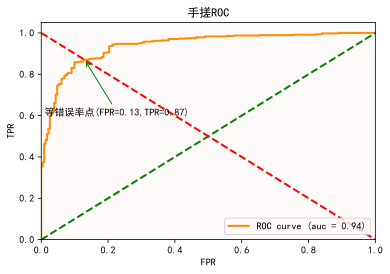

previous lens of FPR : 704
lens of FPR : 466


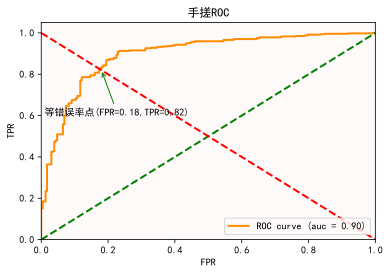

previous lens of FPR : 704
lens of FPR : 451


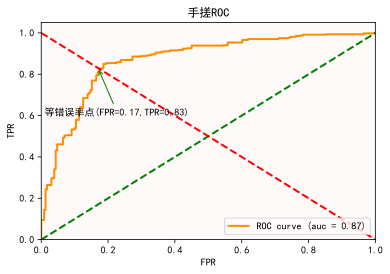

previous lens of FPR : 200
lens of FPR : 131


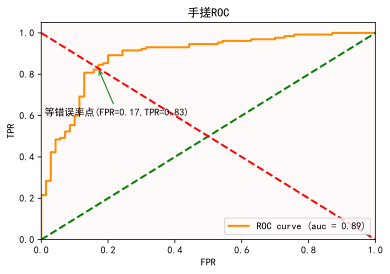

previous lens of FPR : 200
lens of FPR : 132


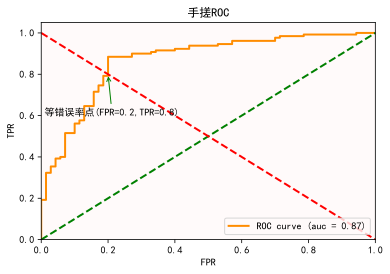

array([-7.35])

In [45]:
#单一特征
ROC2(train_label, train_score1, "男")# 身高
#双特征不相关
ROC2(train_label, train_score4, "男")# 身高 鞋码
#双特征相关
ROC2(train_label, train_score5, "男")# 身高 鞋码

#双特征不相关
ROC2(train_label[0:200], train_score4[0:200], "男")# 身高 鞋码
#双特征相关
ROC2(train_label[0:200], train_score5[0:200], "男")# 身高 鞋码

previous lens of FPR : 704
lens of FPR : 472


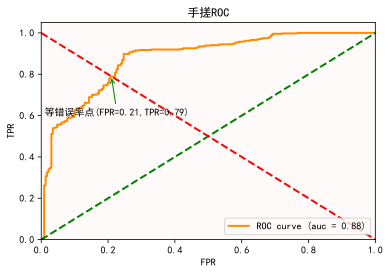

previous lens of FPR : 704
lens of FPR : 435


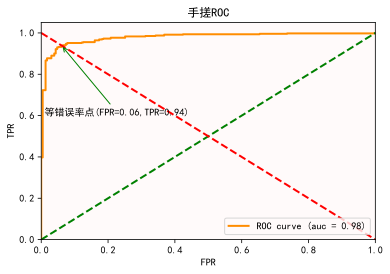

previous lens of FPR : 704
lens of FPR : 432


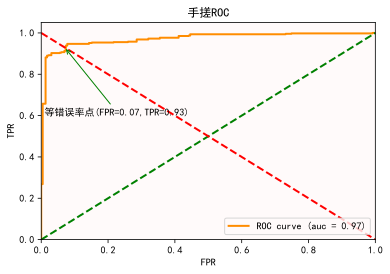

array([-7.52])

In [50]:
#单一特征
ROC2(train_label, train_score2, "男")# 体重
#双特征不相关
ROC2(train_label, train_score6, "男")# 身高 鞋码
#双特征相关
ROC2(train_label, train_score7, "男")# 身高 鞋码

previous lens of FPR : 704
lens of FPR : 472


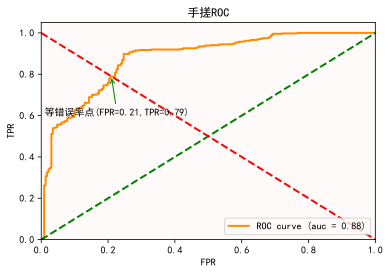

previous lens of FPR : 704
lens of FPR : 437


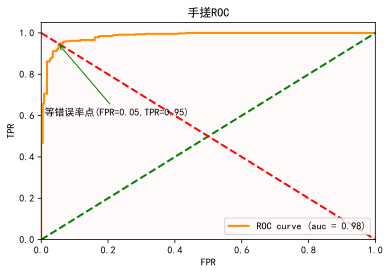

previous lens of FPR : 704
lens of FPR : 427


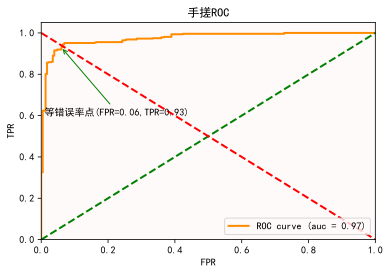

previous lens of FPR : 100
lens of FPR : 66


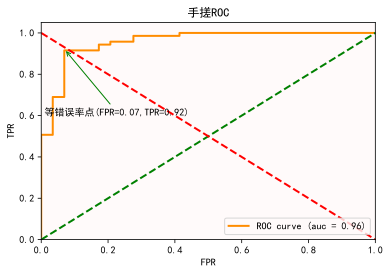

previous lens of FPR : 100
lens of FPR : 65


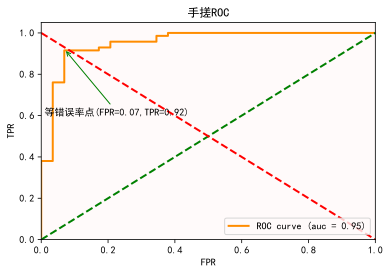

array([-11.14])

In [49]:
#单一特征
ROC2(train_label, train_score2, "男")# 身高
#双特征不相关
ROC2(train_label, train_score8, "男")# 体重 鞋码
#双特征相关
ROC2(train_label, train_score9, "男")# 体重 鞋码

#双特征不相关
ROC2(train_label[0:100], train_score8[0:100], "男")# 体重 鞋码
#双特征相关
ROC2(train_label[0:100], train_score9[0:100], "男")# 体重 鞋码

调库CM

[[460  13]
 [ 99 132]]


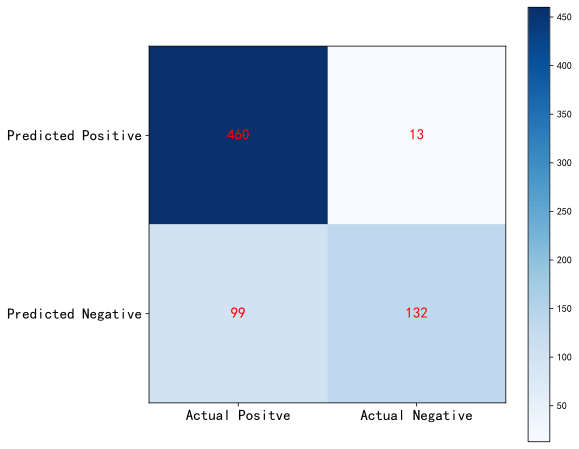

In [39]:
from sklearn.metrics import confusion_matrix

def conf_martrix(y_label, y_pred):
    '''
    para:
    y_label真实标签
    y_pred预测标签
    '''
    cm = confusion_matrix(y_label, y_pred, labels=['男', '女'])
    print(cm)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Predicted Positive', 'Predicted Negative'))
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Actual Positve', 'Actual Negative'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red', size=15)

    plt.tick_params(labelsize=15)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    plt.show()
conf_martrix(train_label, train_pred1)

手搓CM

[[460  13]
 [ 99 132]]
460


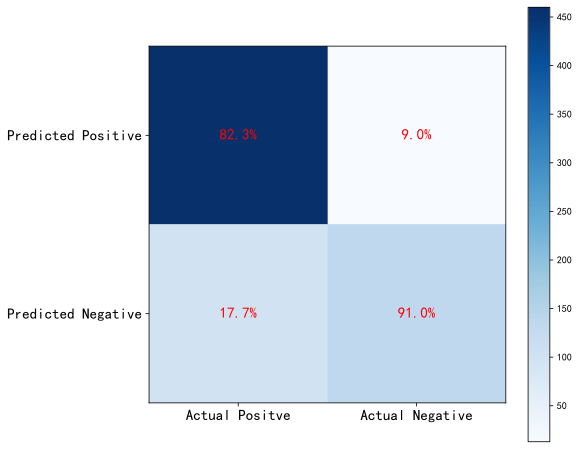

In [33]:

from sklearn.metrics import confusion_matrix

# 手搓CM
def TP(y_true,y_predict):
      assert len(y_true) == len(y_predict)
      return np.sum((y_true == 1)&(y_predict == 1))
def TN(y_label,y_predict):
      assert len(y_label) == len(y_predict)
      return np.sum((y_label == 0)&(y_predict == 0))
def FP(y_true,y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 0)&(y_predict == 1))
def FN(y_true,y_predict):
      assert len(y_true) == len(y_predict)
      return np.sum((y_true == 1)&(y_predict == 0))

def label_to_bool(label_arr,labels = None):
    # False_label = (0,labels[1])[labels == None ]
    lens = len(label_arr)
    if labels == None :
        return label_arr
    else :
        bool_arr = np.ones(lens).astype('int32')
        for i in range(lens):
            if label_arr[i] == labels[1]:
                bool_arr[i] = 0
    return bool_arr

def confusion_matrix2(y_label,y_predict,labels = None):
    y_true = label_to_bool(y_label,labels)
    y_predict = label_to_bool(y_predict,labels)
    return np.array([
          [TP(y_true,y_predict),FN(y_true,y_predict)],
          [FP(y_true,y_predict),TN(y_true,y_predict)]
      ])

def conf_martrix(y_label, y_pred):
    '''
    para:
    y_label真实标签
    y_pred预测标签
    '''
    lens = len(y_label)
    #调库CM
    # cm = confusion_matrix(y_label, y_pred, labels=['男', '女'])
    #手搓CM
    cm = confusion_matrix2(y_label, y_pred, labels=['男', '女'])

    print(cm)
    print(cm[0][0])
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Predicted Positive', 'Predicted Negative'))
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Actual Positve', 'Actual Negative'))
    ax.set_ylim(1.5, -0.5)

    # for i in range(2):
    #     for j in range(2):
    #         ax.text(j, i, cm[i, j], ha='center', va='center', color='red', size=15)
    #
    for i in range(2):
        ax.text(0, i, str(round(cm[i,0]/(cm[0][0]+cm[1][0])*100,1))+'%', ha='center', va='center', color='red', size=15)
    for i in range(2):
        ax.text(1, i, str(round(cm[i,1]/(cm[0][1]+cm[1][1])*100,1))+'%', ha='center', va='center', color='red', size=15)
    plt.tick_params(labelsize=15)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    plt.show()
conf_martrix(train_label, train_pred1)

决策面

[[28.82627867 22.74931413]
 [22.74931413 22.74931413]]
[[25.88309814 17.06883304]
 [17.06883304 17.06883304]]
决策面方程: 0.999999999999976*y - 21.9804054092959*sqrt(0.000592504847647981*y**2 - 0.0183015463567746*y - 1) + 109.411819278479
决策面方程: 0.999999999999976*y + 21.9804054092959*sqrt(0.000592504847647981*y**2 - 0.0183015463567746*y - 1) + 109.411819278479


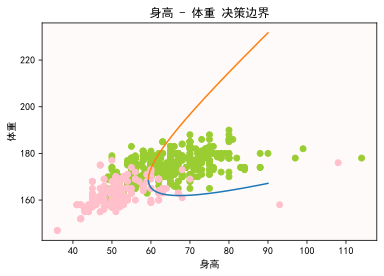

[[28.82627867 22.74931413]
 [22.74931413 22.74931413]]
[[25.88309814 17.06883304]
 [17.06883304 17.06883304]]
决策面方程: 0.999999999999976*y - 22.6769331470287*sqrt(0.000556665960040137*y**2 - 0.0171945392739906*y - 1) + 109.411819278479
决策面方程: 0.999999999999976*y + 22.6769331470287*sqrt(0.000556665960040137*y**2 - 0.0171945392739906*y - 1) + 109.411819278479


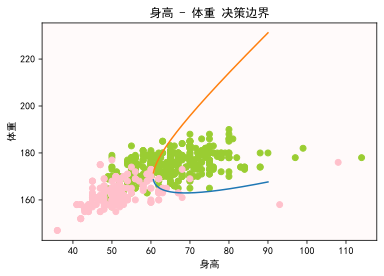

[[80.02130292  5.02227248]
 [ 5.02227248  5.02227248]]
[[57.07666648  3.29771743]
 [ 3.29771743  3.29771743]]
决策面方程: 1.00000000000001*y - 111.286350367425*sqrt(-0.00159808716850717*y**2 + 0.0904707247468418*y - 1) - 4.20275005071697
决策面方程: 1.00000000000001*y + 111.286350367425*sqrt(-0.00159808716850717*y**2 + 0.0904707247468418*y - 1) - 4.20275005071697


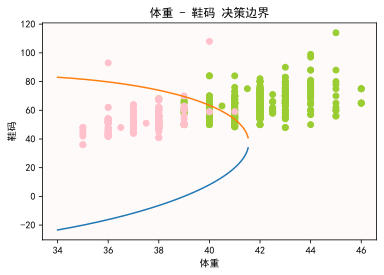

[[80.02130292  5.02227248]
 [ 5.02227248  5.02227248]]
[[57.07666648  3.29771743]
 [ 3.29771743  3.29771743]]
决策面方程: 1.00000000000001*y - 109.920499535441*sqrt(-0.00163804895732978*y**2 + 0.0927330368836318*y - 1) - 4.20275005071697
决策面方程: 1.00000000000001*y + 109.920499535441*sqrt(-0.00163804895732978*y**2 + 0.0927330368836318*y - 1) - 4.20275005071697


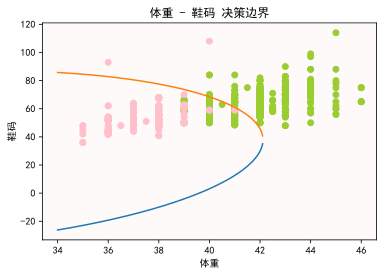

决策面方程: 0.999999999999934*y - 101.362287253842*sqrt(-0.00365588363299607*y**2 + 0.194916278567537*y - 1) + 31.7152245572991
决策面方程: 0.999999999999934*y + 101.362287253842*sqrt(-0.00365588363299607*y**2 + 0.194916278567537*y - 1) + 31.7152245572991


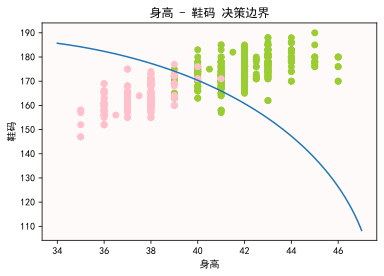

决策面方程: 0.999999999999934*y - 98.7432391550825*sqrt(-0.00385239160859267*y**2 + 0.205393254083506*y - 1) + 31.7152245572991
决策面方程: 0.999999999999934*y + 98.7432391550825*sqrt(-0.00385239160859267*y**2 + 0.205393254083506*y - 1) + 31.7152245572991


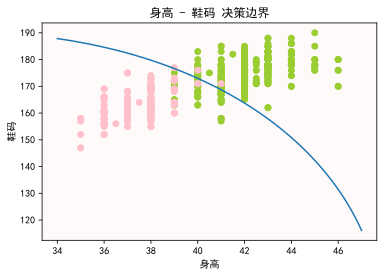

In [38]:

# 用sympy根据
import sympy
from numpy import sqrt
import warnings
warnings.filterwarnings("ignore")

#协方差矩阵计算
def CovEle(Data1,Data2,Mean1,Mean2):
    Length = len(Data1)
    Cov00 = sum(np.multiply(Data1-Mean1, Data1-Mean1))/Length
    Cov01 = sum(np.multiply(Data1-Mean1, Data2-Mean2))/Length
    Cov11 = sum(np.multiply(Data1-Mean2, Data2-Mean2))/Length
    Cov10 = Cov01
    # Cov = sympy.Matrix([[float(Cov00),float(Cov01)],[float(Cov10),float(Cov11)]])
    Cov = np.array([[Cov00.astype('float64'),Cov01.astype('float64')],[Cov10.astype('float64'),Cov11.astype('float64')]])
    return Cov

def DecisionPlaneSolve(data,label,feature1,feature2,sigma):

    male_fea1 = data[label == '男'][:, feature1]
    female_fea1 = data[label == '女'][:, feature1]
    male_fea2 = data[label == '男'][:, feature2]
    female_fea2 = data[label == '女'][:, feature2]
    #   计算均数
    Boymu1 = np.mean(male_fea1)
    Boymu2 = np.mean(male_fea2)
    Girlmu1 = np.mean(female_fea1)
    Girlmu2 = np.mean(female_fea2)
    # Boymu1, Girlmu1, _, _ = feature_extract(data, label, feature1)# X11 X21
    # Boymu2, Girlmu2, _, _ = feature_extract(data, label, feature2) # X12 X22
    N = len(data)

    BoyClassMean = sympy.Matrix([[Boymu1], [Boymu2]])  # Mean1
    GirClassMean = sympy.Matrix([[Girlmu1], [Girlmu2]])  #
    # 协方差矩阵
    BoyCov= CovEle(male_fea1, male_fea2, Boymu1, Boymu2)
    GirCov = CovEle(female_fea1, female_fea2, Girlmu1, Girlmu2)

    print(BoyCov)
    print(GirCov)
    # ln( |Cov1| / |Cov2| )
    ln_Cov = sympy.ln(np.linalg.det(BoyCov)/np.linalg.det(GirCov))
    # ln( P(w1) / P(w2) )
    # ln_P_w = sympy.ln( (len(male_fea1)/N) / (len(female_fea1)/N) )
    ln_pre = sympy.ln(sigma) / (1-sigma)
     # 根据决策面方程列式求解决策函数
    x, y = sympy.symbols('x y') #对应fea1 fea2
    Func = sympy.Matrix((0.5 * (np.matrix([[x],[y]]) - BoyClassMean).T * np.linalg.inv(BoyCov) * (np.matrix([[x],[y]]) - BoyClassMean))) .det() \
           -sympy.Matrix((0.5 * (np.matrix([[x], [y]]) - GirClassMean).T * np.linalg.inv(GirCov) * (np.matrix([[x], [y]]) - GirClassMean))).det() \
           + 0.5 * ln_Cov - ln_pre
    #决策面显示
    SolveFunc = sympy.solve(Func, [x, y])# 求解函数得两个解

    y_coor = {0: 'np.linspace(146, 198, 500)', 1: 'np.linspace(40, 90, 500)', 2: 'np.linspace(34, 47, 500)'}     #对应身高体重鞋码 范围划定纵坐标标点

    y = eval(y_coor.get(feature2))
    BD = np.array(SolveFunc)#决策面
    print("决策面方程: "+str(BD[0][0]))#可能的决策面方程1
    print("决策面方程: "+str(BD[1][0]))#可能的决策面方程2

    X_Fea1_1 = eval(str(BD[0][0]))
    plt.plot(y, X_Fea1_1)
    X_Fea1_2 = eval(str(BD[1][0]))
    plt.plot(y, X_Fea1_2)

    #参考:升高体重一个普遍正确的决策面方程
    # X_Fea1 = 0.247822699671129 *y + 79.3792911179188 * np.sqrt(
    #      -0.000932386643406855 * y ** 2 + 0.083558110408116 * y - 1) + 82.8949394272113
    # plt.plot(y, X_Fea1)
    #男女特征点显示
    f = {0: '身高', 1: '体重', 2: '鞋码'}
    plt.scatter(male_fea2, male_fea1, color='yellowgreen')
    plt.scatter(female_fea2, female_fea1, color='pink')
    plt.xlabel(f.get(feature1))
    plt.ylabel(f.get(feature2))
    plt.title(f.get(feature1)+' - '+f.get(feature2) +' 决策边界' )
    plt.show()
    return SolveFunc


m = DecisionPlaneSolve(train_data,train_label,0,1,0.9)
m = DecisionPlaneSolve(train_data,train_label,0,1,0.25)
m = DecisionPlaneSolve(train_data,train_label,1,2,0.9)
m = DecisionPlaneSolve(train_data,train_label,1,2,0.25)
# m = DecisionPlaneSolve(train_data,train_label,0,2,0.9)
# m = DecisionPlaneSolve(train_data,train_label,0,2,0.25)


## 2. 应用两个特征进行实验
同时采用**身高和体重**数据作为特征，假设二者不相关，在正态分布假设下估计概率密度，建立最小错误率Bayes分类器，写出得到的决策规则，将该分类器应用到训练/测试样本，考察训练/测试错误情况。在分类器设计时可以考察采用不同先验概率（如0.5 vs. 0.5, 0.75 vs. 0.25, 0.9 vs. 0.1 等）进行实验，考察对决策规则和错误率的影响。

# 3 Parzen窗法
采用Parzen窗法估计概率密度，重复步骤（1），并且进行比较

In [ ]:
def gauss_kernel(x):
    """
    高斯核
    """
    return (1/math.sqrt(2*math.pi))*math.exp(-0.5*(x**2))

def tophat_kernel(x):
    """
    方框核
    """
    if abs(x)<=1:
         return 1/2
    else:
        return 0

def get_kde(x,data_array,bandwidth=0.1,kernel='gauss'):
    """
    核密度估计
   
    """
    N=float(len(data_array))  
    res=0
    if len(data_array)==0:
        return 0
    for i in range(len(data_array)):
        if kernel=='gauss':
            res += gauss_kernel(float(x-data_array[i])/bandwidth)
        else:
            res += tophat_kernel(float(x-data_array[i])/bandwidth)
    res /= (N*bandwidth)
    return res

def feature_extract(data, label, feature):
    male_data = data[label == '男'][:, feature]
    female_data = data[label == '女'][:, feature]
    return male_data, female_data

def posterior(x,data, feature,kernel='gauss'):
    '''
    计算后验概率
    '''
    p = get_kde(x,data,0.5,kernel)
    return p

# pre = [0.5, 0.75, 0.9] # 先验概率
#     pre_male = pre[0]
#     pre_female = 1 - pre_male
def plot_kde(sex_data):
    '''
    绘制核密度估计图
    '''
    result=[]
    x=[]
    for i in range(int(sex_data.min())*10,int(sex_data.max())*10):
         result.append(get_kde(i/10.0,sex_data,1,'gauss'))
         x.append(float(i/10.0))
    plt.figure(figsize=(8, 8)) 
    plt.plot(x,result)    
    plt.plot(sex_data, -0.005 - 0.01 * np.random.random(sex_data.shape[0]), "+k")

def bayes(data, feature):
    '''
    贝叶斯决策
    '''
    label_pred = []
    male_data, female_data = feature_extract(train_data, train_label, feature)
    plot_kde(male_data)
    plot_kde(female_data)
#     pre_male = len(male_data)/(len(male_data)+len(female_data))        # 先验概率
    pre = [0.6704545454545454,0.5, 0.75,0.9]
    pre_male=pre[0]
    pre_female = 1 - pre_male
    for i in range(len(data)):
        p1 = posterior(data[i, feature],male_data,feature,'gauss')
        if p1>0.8:
            print(p1)
        p2 = posterior(data [i, feature],female_data,'gauss')      
        if pre_male*p1 > pre_female*p2:
            label_pred.append('男')
        else:
            label_pred.append('女')
    return label_pred

def accuracy(label_pred, label):
    acc = 0
    for i in range(len(label)):
        if label_pred[i] == label[i]:
            acc += 1
    return acc/len(label)

In [ ]:
accuracy(bayes(train_data, 0), train_label)

In [ ]:
accuracy(bayes(test_data, 0), test_label)

# 4 最小风险决策

In [ ]:
def mean(x):
    '''
    计算均值
    '''
    mu = 0
    for i in range(len(x)):
        mu += x[i]
    return mu/len(x)

def std(x):
    '''
    计算标准差
    '''
    sigma = 0
    for i in range(len(x)):
        sigma += (x[i] - mean(x))**2
    return np.sqrt(sigma/len(x))

def gaussian(x, mu, sigma):
    '''
    计算高斯分布
    '''
    return np.exp(-((x-mu)**2)/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

def feature_extract(data, label, feature):
    male_data = data[label == '男'][:, feature]
    female_data = data[label == '女'][:, feature]
    return mean(male_data), mean(female_data), std(male_data), std(female_data)

def posterior(x, mu1, mu2, sigma1, sigma2):
    '''
    计算后验概率
    '''
    pre = [0.5, 0.75, 0.9] # 先验概率
    pre_male = pre[0]
    pre_female = 1 - pre_male
    p1 = gaussian(x, mu1, sigma1)
    p2 = gaussian(x, mu2, sigma2)
    return pre_male*p1/(pre_male*p1 + pre_female*p2), pre_female*p2/(pre_male*p1 + pre_female*p2)

def bayes(data, label, feature):
    mu1, mu2, sigma1, sigma2 = feature_extract(data, label, feature)
    label_pred = []
    for i in range(len(data)):
        p1, p2 = posterior(data[i, feature], mu1, mu2, sigma1, sigma2)
        if p1 > p2:
            label_pred.append('男')
        else:
            label_pred.append('女')
    return label_pred

# 从traindata训练，并预测testdata，并支持多维数据或待预测的数据数组
def bayessingle(traindata, trainlabel, feature, testdata):
    mu1, mu2, sigma1, sigma2 = feature_extract(traindata, trainlabel, feature)
    label_pred = []
    for i in range(len(testdata)):
        try:
            p1, p2 = posterior(testdata[i,feature], mu1, mu2, sigma1, sigma2)
        except:
            p1, p2 = posterior(testdata[i], mu1, mu2, sigma1, sigma2)
        if p1 > p2:
            label_pred.append('男')
        else:
            label_pred.append('女')
    return label_pred

# 仅返回p1、p2，供画图用
def bayesprob(traindata, trainlabel, feature, testdata):
    mu1, mu2, sigma1, sigma2 = feature_extract(traindata, trainlabel, feature)
    prob = []
    def calp(x, mu1, mu2, sigma1, sigma2):
        p1 = gaussian(x, mu1, sigma1)
        p2 = gaussian(x, mu2, sigma2)
        return p1,p2
    for i in range(len(testdata)):
        prob.append(calp(testdata[i], mu1, mu2, sigma1, sigma2))

    return prob


def accuracy(label_pred, label):
    acc = 0
    for i in range(len(label)):
        if label_pred[i] == label[i]:
            acc += 1
    return acc/len(label)

1. 利用贝叶斯公式计算后验概率
$$
P( w_j|x )  = \frac{p(x|w_j)p(w_j)}{\sum_{i=1}^c p(x|w_i)P(w_i)}
$$

2. 利用决策表，计算条件风险
$$
R(\alpha_i|x) = \sum_{j=1}^c \lambda(\alpha_i|w_j)P(w_j|x)
$$

3. 决策：在各种决策中选择风险最小的决策，即
$$
\alpha = arg\min_{i=1,\cdots,k}R(\alpha_i|x)
$$

对于二分类问题：
即比较
$$
\lambda_{11}P(w_1|x)+\lambda_{12}P(w_2|x)
$$
和
$$
\lambda_{21}P(w_1|x)+\lambda_{22}P(w_2|x)
$$
我们可以使用一个二维数组来储存决策表，例如`np.array([[0,1],[6,0]])`即表示
决策表：
|                      | 实际为男性$w_1$ | 实际为女性$w_2$ |
| :------------------: | :-------------: | :-------------: |
| 判断为男性$\alpha_1$ |        0        |        6        |
| 判断为女性$\alpha_2$ |        1        |        0        |

In [ ]:
def bayeswithrisk(traindata, trainlabel, feature, testdata, risk):
    mu1, mu2, sigma1, sigma2 = feature_extract(traindata, trainlabel, feature)
    label_pred = []
    for i in range(len(testdata)):
        try:
            prob = numpy.array(posterior(testdata[i, feature], mu1, mu2, sigma1, sigma2))
        except:
            prob = numpy.array(posterior(testdata[i], mu1, mu2, sigma1, sigma2))
        p1 = numpy.dot(risk[1],prob)
        p2 = numpy.dot(risk[0],prob)
        if p1 > p2:
            label_pred.append('男')
        else:
            label_pred.append('女')
    return label_pred

In [ ]:
accuracy(bayessingle(train_data, train_label, 0, test_data), test_label)

In [ ]:
accuracy(bayeswithrisk(train_data,train_label,0,test_data,np.array([[0,1],[1,0]])),test_label)

In [ ]:
accuracy(bayeswithrisk(train_data,train_label,0,test_data,np.array([[0,1],[2,0]])),test_label)